In [1]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install kagglehub

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import re
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    logging
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub

In [4]:
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/Tweets.csv")
df.head() 

Path to dataset files: /kaggle/input/datasets/organizations/crowdflower/twitter-airline-sentiment


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    #text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['text'] = df['text'].fillna('')
df['clean_text'] = df['text'].apply(clean_text)

print(df[['text','clean_text']].head(10))

                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   
5  @VirginAmerica seriously would pay $30 a fligh...   
6  @VirginAmerica yes, nearly every time I fly VX...   
7  @VirginAmerica Really missed a prime opportuni...   
8    @virginamerica Well, I didn't…but NOW I DO! :-D   
9  @VirginAmerica it was amazing, and arrived an ...   

                                          clean_text  
0                                        what  said.  
1   plus you've added commercials to the experien...  
2   i didn't today... must mean i need to take an...  
3   it's really aggressive to blast obnoxious "en...  
4           and it's a really big bad thing about it  
5   seriously would pay $30 a flight for seats th... 

In [6]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['airline_sentiment']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['airline_sentiment']
)
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]],preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "label"]],preserve_index=False)


def tokenize_fn(example):
    return tokenizer(
        example['clean_text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset   = val_dataset.map(tokenize_fn, batched=True)

train_dataset = train_dataset.remove_columns(['clean_text'])
val_dataset   = val_dataset.remove_columns(['clean_text'])

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset   = val_dataset.rename_column("label", "labels")

train_dataset.set_format('torch')
val_dataset.set_format('torch')

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/2196 [00:00<?, ? examples/s]

In [8]:
print(len(df))
print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

14640
Train: 10248
Val: 2196
Test: 2196


In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=3,
   
    learning_rate=5e-6,

    eval_strategy="steps",
    eval_steps=50,

    logging_strategy="steps",
    logging_steps=50,

    save_strategy="steps",
    save_steps=50,

    save_total_limit=1,  

    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    weight_decay=0.01,
    report_to="none"
)

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1
50,0.897203,0.903947,0.828780,0.824745
100,0.859577,0.835371,0.842441,0.840524
150,0.781189,0.815139,0.849727,0.846828
200,0.809418,0.800535,0.851093,0.850783
250,0.831347,0.783659,0.852004,0.850455
300,0.747369,0.784527,0.852459,0.849788
350,0.781621,0.761498,0.856102,0.854652
400,0.643969,0.798416,0.851093,0.850650
450,0.666020,0.773186,0.859290,0.858515
500,0.649326,0.764481,0.858379,0.858162


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

{'eval_loss': 0.7535321116447449,
 'eval_accuracy': 0.8620218579234973,
 'eval_f1': 0.8617104078105182,
 'eval_runtime': 12.957,
 'eval_samples_per_second': 169.484,
 'eval_steps_per_second': 10.651,
 'epoch': 3.0}

In [13]:
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

df_logs.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.897203,10.123598,0.000005,0.155763,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.155763,50,0.903947,0.828780,0.824745,12.4450,176.457,11.089,NaN,NaN,NaN,NaN,NaN
2,0.859577,18.451574,0.000004,0.311526,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.311526,100,0.835371,0.842441,0.840524,12.4697,176.108,11.067,NaN,NaN,NaN,NaN,NaN
4,0.781189,17.705034,0.000004,0.467290,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train_loss = df_logs[df_logs["loss"].notna()]
eval_loss = df_logs[df_logs["eval_loss"].notna()]

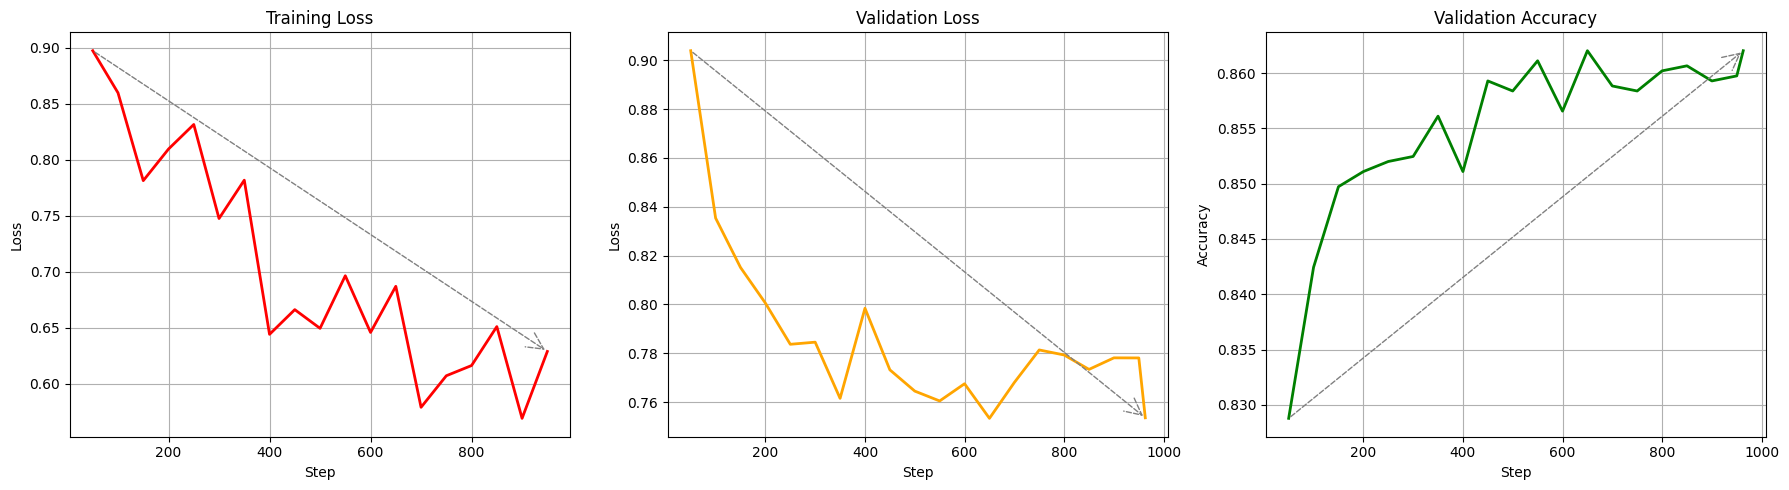

In [15]:
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

train_loss = df_logs[df_logs["loss"].notna()]
eval_loss = df_logs[df_logs["eval_loss"].notna()]
eval_acc  = df_logs[df_logs["eval_accuracy"].notna()]

plt.figure(figsize=(18,5))

# 1️⃣ Training Loss
plt.subplot(1,3,1)
plt.plot(train_loss["step"], train_loss["loss"],color="red", linewidth=2)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

x_start = train_loss["step"].iloc[0]
y_start = train_loss["loss"].iloc[0]
x_end = train_loss["step"].iloc[-1]
y_end = train_loss["loss"].iloc[-1]
plt.annotate(
    "",
    xy=(x_end, y_end),         
    xytext=(x_start, y_start),  
    arrowprops=dict(
        arrowstyle="->",
         linestyle="--",
         color="gray",
         linewidth=1,
         mutation_scale=30))


plt.subplot(1,3,2)
plt.plot(eval_loss["step"], eval_loss["eval_loss"],color="orange", linewidth=2)
plt.title("Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
x_start = eval_loss["step"].iloc[0]
y_start = eval_loss["eval_loss"].iloc[0]
x_end = eval_loss["step"].iloc[-1]
y_end = eval_loss["eval_loss"].iloc[-1]
plt.annotate(
    "",
    xy=(x_end, y_end),          
    xytext=(x_start, y_start),  
    arrowprops=dict(
        arrowstyle="->",
         linestyle="--",
         color="gray",
         linewidth=1,
         mutation_scale=30))

plt.subplot(1,3,3)
plt.plot(eval_acc["step"], eval_acc["eval_accuracy"],color="green", linewidth=2)
plt.title("Validation Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)
x_start = eval_acc["step"].iloc[0]
y_start = eval_acc["eval_accuracy"].iloc[0]
x_end = eval_acc["step"].iloc[-1]
y_end = eval_acc["eval_accuracy"].iloc[-1]
plt.annotate(
    "",
    xy=(x_end, y_end),         
    xytext=(x_start, y_start), 
    arrowprops=dict(
        arrowstyle="->",
         linestyle="--",
         color="gray",
         linewidth=1,
         mutation_scale=30))

plt.tight_layout()
plt.show()



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [17]:
labels = ['negative', 'neutral', 'positive']

true_labels = test_df['label'].tolist()

batch_size = 100
all_predictions = []

model.eval()

for i in tqdm(range(0, len(test_df), batch_size)):
    
    batch_texts = test_df['clean_text'][i:i+batch_size].tolist()
    
    tokens = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    
    tokens = {k: v.to(device) for k, v in tokens.items()}
    
    with torch.no_grad():
        outputs = model(**tokens)
        preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
        batch_predicted_classes = preds.argmax(dim=1).cpu().tolist()
        all_predictions.extend(batch_predicted_classes)

test_df['predicted_label'] = [labels[i] for i in all_predictions]

100%|██████████| 22/22 [00:05<00:00,  4.32it/s]


In [18]:
test_df['true_label'] = [labels[i] for i in test_df['label']]
y_true = test_df['true_label']
y_pred = test_df['predicted_label']

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", acc)
print("F1-score:", f1)

Accuracy: 0.8542805100182149
F1-score: 0.8523058917877461


In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    negative       0.90      0.93      0.91      1377
     neutral       0.74      0.66      0.70       465
    positive       0.80      0.82      0.81       354

    accuracy                           0.85      2196
   macro avg       0.81      0.81      0.81      2196
weighted avg       0.85      0.85      0.85      2196



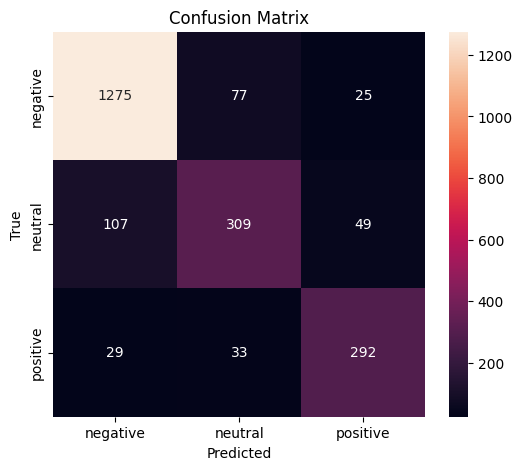

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()